In [63]:
import os
import torch
import random
import pickle
import numpy as np
import pandas as pd
import torch.nn as torchNN
import torch.nn.functional as torchF
import matplotlib.pyplot as plt
import gymnasium as gym

from itertools import count
from IPython import display
from collections import namedtuple, deque
from torchsummary import summary
from skimage.color import rgb2gray

%matplotlib inline

In [64]:
#TODO: 提高线性层的神经元个数, 图像预处理( 帧合并, 颜色处理, 归一化 ), 重载 Reward (统计 非黑 像素点), 提高训练次数

In [65]:
Transition = namedtuple('Transition', ('nowState', 'action', 'nextState', 'reward'))
class MemoryPool():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen = capacity)
    
    def AddMemory(self, *arg):
        self.memory.append(Transition(*arg))
    
    def Sample(self, BATCHSIZE):
        return random.sample(self.memory, BATCHSIZE)

    def SaveToDisk(self, PATH):
        with open(PATH, 'ab') as f:
            pickle.dump(self.memory, f)
    
    def Load(self, PATH):
        with open(PATH, 'rb') as f:
            self.memory = pickle.load(f)

    def __len__(self):
        return len(self.memory)

In [66]:

class Network(torchNN.Module):
    def __init__(
        self, 
        stateShape, 
        actionNum, 
        linerHiddenUnits, 
        rnnHiddenUnits,
        rnnHiddenLayers,
        timeScale,
    ) -> None:
        '''
        stateShape: (height, weight, depth)
        '''
        
        super(Network, self).__init__()

        self.conv1 = torchNN.Sequential(
            torchNN.Conv2d(
                in_channels = timeScale,
                out_channels = 32,
                kernel_size = 8,
                stride = 4,
            ),
            torchNN.LeakyReLU(),
            torchNN.MaxPool2d(2)
        )
        
        self.conv2 = torchNN.Sequential(
            torchNN.Conv2d(
                in_channels = 32,
                out_channels = 64,
                kernel_size = 4,
                stride = 2,
            ),

            torchNN.LeakyReLU(),
            torchNN.MaxPool2d(2)
        )

        # 整合成单通道
        self.conv3 = torchNN.Sequential(
            torchNN.Conv2d(
                in_channels = 64,
                out_channels = 64,
                kernel_size = 3,
                stride = 1,
            ),

            torchNN.LeakyReLU(),
            torchNN.MaxPool2d(2)
        )
        
        # 64 个通道为 一个像素点的编码
        self.ltsm = torchNN.LSTM(
            input_size = 64,
            hidden_size = rnnHiddenUnits,
            num_layers = rnnHiddenLayers,
            batch_first = True,
        )

        self.liner = torchNN.Sequential(
            torchNN.Linear(in_features = rnnHiddenUnits, out_features = linerHiddenUnits),
            torchNN.LeakyReLU(),
            torchNN.Linear(in_features = linerHiddenUnits, out_features = linerHiddenUnits // 2),
            torchNN.LeakyReLU(),
            torchNN.Linear(in_features = linerHiddenUnits // 2, out_features = linerHiddenUnits // 4),
            torchNN.LeakyReLU(),
            torchNN.Linear(in_features = linerHiddenUnits // 4, out_features = actionNum),
        )

        self.rnnHiddenUnits = rnnHiddenUnits
        self.rnnHiddenLayers = rnnHiddenLayers
        self.timeScale = timeScale

        for layer in self.ltsm.parameters():
            torchNN.init.normal_(layer, mean = 0.0, std = 0.001)

    def InitHidden(self, batchSize):
        weight = next(self.parameters()).data
        hidden = weight.new(self.rnnHiddenLayers, batchSize, self.rnnHiddenUnits).zero_(), weight.new(self.rnnHiddenLayers, batchSize, self.rnnHiddenUnits).zero_()

        return hidden

    def forward(self, inputData, batchSize):
        x = self.conv1(inputData)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the img(h, w) -> (h * w)
        x = x.view(x.size(0), 64, 1 * 1)
        x = x.permute((0, 2, 1))

        hidden = self.InitHidden(batchSize)
        x, _ = self.ltsm(x, hidden)

        x = self.liner(x[:, -1, :])

        return x

    def Predict(self, inputData, batchSize):
        x = self.conv1(inputData)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the img(h, w) -> (h * w)
        x = x.view(x.size(0), 64, 1 * 1)
        x = x.permute((0, 2, 1))

        hidden = self.InitHidden(batchSize)
        x, _ = self.ltsm(x, hidden)

        x = self.liner(x[:, -1, :])

        return x

In [67]:
class DQNModel():
    def __init__(
        self,
        stateNum,
        actionNum,
        hiddenUnits,
        episold,
        poolCapacity,
        environment,
        learningRate,
        batchSize,
        gamma,
        sigma,
        epsStart,
        epsEnd,
        epsDecay,
        rnnHiddenUnits,
        rnnHiddenLayers,
        timeScale, 
    ):
        '''
        Param:
            stateNum: 
            actionNum:
            hiddenUnits:
            episold:
            poolCapacity:
            environment:
            learningRate:
            gamma:
            sigma:
            timeScale: the number of frame to wait
        '''

        self.policyNetwork = Network(stateNum, actionNum, hiddenUnits, rnnHiddenUnits, rnnHiddenLayers, timeScale)
        self.targetNetwork = Network(stateNum, actionNum, hiddenUnits, rnnHiddenUnits, rnnHiddenLayers, timeScale)
        
        self.targetNetwork.load_state_dict(self.policyNetwork.state_dict())

        self.episold = episold
        self.memoryPool = MemoryPool(poolCapacity)
        self.environment = environment
        self.optimizer = torch.optim.Adam(self.policyNetwork.parameters(), lr = learningRate)
        self.lossFunc = torchNN.SmoothL1Loss()                      # use L1 lossfunction
        self.batchSize = batchSize
        self.gamma = gamma
        self.sigma = sigma

        self.epsStart = epsStart
        self.epsEnd = epsEnd
        self.epsDecay = epsDecay
        self.chooseStep = 0
        
        self.timeScale = timeScale

        self.rnnHiddenUnits = rnnHiddenUnits
        self.rnnHiddenLayers = rnnHiddenLayers
        
        self.chooseActionHidden = self.policyNetwork.InitHidden(1)
        self.trainingHidden = self.policyNetwork.InitHidden(self.batchSize)

    def LoadNetwork(self, savedPath):
        self.policyNetwork.load_state_dict(torch.load(savedPath))
        self.targetNetwork.load_state_dict(torch.load(savedPath))

    def SaveNetwork(self, savedPath):
        torch.save(self.policyNetwork.state_dict(), savedPath)

    def ModelChoose(self, nowState):
        with torch.no_grad():
            actions = self.policyNetwork.Predict(nowState, 1)
            return actions.max(1).indices.view(1, 1) 

    def Reward(self, img, reward, step, action, done) -> torch.float32:
        '''
        reward:
            about the time you stay, and the score you gain
        '''
        # if done:
        #     return -100.0

        # return reward * 20 + step * 3
        # 对不做动作的惩罚
        if action == 0:
            return -10000

        return reward
    
    def ChooseAction(self, nowState):
        '''
        Func:
            return the next action agent may take
        Param:
            nowState:   the state agent is in
        Return:
            shape:      (1, 1), the first d is used for 'BatchSize'      
        '''
        eps = self.epsEnd + (self.epsStart - self.epsEnd) * np.exp(-1.0 * self.chooseStep / self.epsDecay)
        
        self.chooseStep += 1

        if random.random() < eps:
            return torch.tensor([[self.environment.action_space.sample()]], dtype = torch.long)
        
        with torch.no_grad():
            # return self.policyNetwork(nowState, self.chooseActionLTSMStateH, self.chooseActionLTSMStateC).max(1).indices.view(1, 1)   
            actions = self.policyNetwork.Predict(torch.unsqueeze(nowState, 0), 1)
            return actions.max(1).indices.view(1, 1)  
        
    def OptimizeNetwork(self):
        if len(self.memoryPool) < self.batchSize:
            return

        data = self.memoryPool.Sample(self.batchSize)
        data = Transition(*zip(*data))

        # 剔除结束回合的步子
        noneFinalNextStateMask = torch.tensor( tuple( map( lambda state: state is not None, data.nextState ) ), dtype = torch.bool)     # shape do not change
        noneFinalnextState = torch.stack( [state for state in data.nextState if state is not None] )

        nowStateMemory = torch.stack(data.nowState)
        actionMemory = torch.cat(data.action)
        rewardMemory = torch.cat(data.reward)
        
        assert(nowStateMemory.shape == (self.batchSize, 8, 210, 160))

        predictQ = self.policyNetwork(nowStateMemory, self.batchSize)

        predictQ = predictQ.gather(1, actionMemory)

        targetQ = torch.zeros(self.batchSize)
        with torch.no_grad():
            # targetQ[noneFinalNextStateMask] = self.targetNetwork(noneFinalnextState).max(1).values                                      # 求最大值, 但是凭借成BATCHSIZE的大小, 方便进行数学运算
            target = self.targetNetwork(noneFinalnextState, self.batchSize)
            targetQ[noneFinalNextStateMask] = target.max(1).values
        targetQ = (targetQ * self.gamma) + rewardMemory

        self.optimizer.zero_grad()
        loss = self.lossFunc(targetQ.unsqueeze(1), predictQ)
        
        loss.backward()
        
        torchNN.utils.clip_grad_value_(self.policyNetwork.parameters(), 100)

        self.optimizer.step()

        return loss.data.numpy()

    def TranslateImg(self, img) -> torch.Tensor:
        '''
        Func:
            translate the rgb => gray
            map the pixel into [-1, 1]
        return:
            shape:[1, w, h]
        '''
        temp = torch.tensor(rgb2gray(img) / 127.5 - 1.0, dtype = torch.float32)
        # return torch.unsqueeze(temp, dim = 0)
        return temp

    def TrainOneEpoch(self, savedPath):
        '''
        Func:
        Return:
        '''
        startStates = []
        startState, info = self.environment.reset()

        startStates.append(self.TranslateImg(startState))
        
        for i in range(self.timeScale - 1):
            startState, reward, terminated, truncated, _ = self.environment.step(0)
            startStates.append(self.TranslateImg(startState))

        nowState = torch.tensor(np.array(startStates))
        
        # assert(nowState.shape == (8, 210, 160))

        lossSum = 0.0
        rewardSum = 0.0

        for stepNum in count():
            action = self.ChooseAction(nowState)
            observations = []
            # 先执行一次动作
            observation, reward, terminated, truncated, _ = self.environment.step(action.item())
            observations.append(self.TranslateImg(observation))

            # 然后 停帧 -> 模拟人类
            for i in range(self.timeScale - 1):
                observationTemp, reward, terminated, truncated, _ = self.environment.step(0)                            # none operation
                done = terminated or truncated
                if done:
                    stepNum + 1, lossSum, rewardSum

                observations.append(self.TranslateImg(observationTemp))
            
            # observation = self.TranslateImg(observation)

            reward = self.Reward(torch.tensor(observation, dtype = torch.float32), reward, stepNum, done)
            rewardSum += reward
            reward = torch.tensor([reward])

            nextState = torch.tensor(np.array(observations), dtype = torch.float32)
            # done = terminated or truncated

            # observation = np.transpose(observation, (2, 0, 1))                      # permute
            
            # if terminated:
            #     nextState = None
            # else:
            # nextState = torch.tensor(observation, dtype = torch.float32).unsqueeze(0)
            # nextState = torch.tensor(observation, dtype = torch.float32)

            # nextState = observation
            
            # assert(nextState.shape == (1, 210, 160))
            # assert(nowState.shape == (1, 210, 160))

            self.memoryPool.AddMemory(nowState, action, nextState, reward)

            nowState = nextState

            lossTemp = self.OptimizeNetwork()

            if lossTemp != None:
                lossSum += lossTemp

            targetNetworkDict = self.targetNetwork.state_dict()
            policyNetworkDict = self.policyNetwork.state_dict()

            for key in policyNetworkDict:
                targetNetworkDict[key] = policyNetworkDict[key] * self.sigma + targetNetworkDict[key] * (1 - self.sigma)
            self.targetNetwork.load_state_dict(targetNetworkDict)

            if (stepNum + 1) % 50 == 0:
                self.SaveNetwork(savedPath)
                
            if done:
                return stepNum + 1, lossSum, rewardSum
        

In [68]:
env = gym.make("ALE/Skiing-v5")
STATENUM = env.observation_space.shape
ACTIONNUM = env.action_space.n
HIDDENUNITS = 128
EPISOLD = 0.6
POOLCAPACITY = 10000
LR = 0.003
BATCHSIZE = 256
GAMMA = 0.9
SIGMA = 0.005
EPOCHES = 10
SAVEDPATH = '../SavedModel/DQN/DQRN.pth'
CALLBACK = '../CallBack/DQN/DQRN.csv'
MEMORYSAVE = '../CallBack/DQN/Memory.bin'
EPSSTART = 0.9
EPSEND = 0.05
EPSDECAY = 1000

RNNHIDDENUNITS = 128
RNNHIDDENLAYERS = 2

TIMESCALE = 8                       # 停留八帧后运行

#TODO: rebuild the reward function
dqnNetwork = DQNModel(
    STATENUM,
    ACTIONNUM,
    HIDDENUNITS,
    EPISOLD,
    POOLCAPACITY,
    env,
    LR,
    BATCHSIZE,
    GAMMA,
    SIGMA,
    EPSSTART,
    EPSEND,
    EPSDECAY,
    RNNHIDDENUNITS,
    RNNHIDDENLAYERS,
    TIMESCALE
)

In [69]:
if os.path.exists(SAVEDPATH):
    dqnNetwork.LoadNetwork(SAVEDPATH)

if os.path.exists(MEMORYSAVE):
    dqnNetwork.memoryPool.Load(MEMORYSAVE)

history = {
    'step': [],
    'loss': [],
    'reward': [],
}

if os.path.exists(CALLBACK):
    backValue = pd.read_csv(CALLBACK)
    history['step'] += list(backValue['step'])
    history['loss'] += list(backValue['loss'])
    history['reward'] += list(backValue['reward'])

meanPlot = 0

for i in range(EPOCHES):
    step, loss, reward = dqnNetwork.TrainOneEpoch(SAVEDPATH)
    history['step'].append(step)
    history['loss'].append(loss)
    history['reward'].append(reward)
    
    meanPlot += step
    # if (i + 1) % 5 == 0:
    dqnNetwork.SaveNetwork(SAVEDPATH)
    dqnNetwork.memoryPool.SaveToDisk(MEMORYSAVE)

    print("Epochs: %d, Step: %d, Reward: %.2f, loss: %.2f" % (i + 1, step, reward, loss))

meanPlot /= EPOCHES
print(meanPlot)
callbackCSV = pd.DataFrame(history)
callbackCSV.to_csv(CALLBACK)

Epochs: 1, Step: 152, Reward: -1019.00, loss: 86.31
Epochs: 2, Step: 131, Reward: -878.00, loss: 17.90
Epochs: 3, Step: 208, Reward: -1397.00, loss: 27.77
Epochs: 4, Step: 123, Reward: -824.00, loss: 17.32
Epochs: 5, Step: 150, Reward: -11010.00, loss: 23.14
Epochs: 6, Step: 107, Reward: -716.00, loss: 1070.61
Epochs: 7, Step: 73, Reward: -486.00, loss: 597.08
Epochs: 8, Step: 141, Reward: -945.00, loss: 1585.52
Epochs: 9, Step: 98, Reward: -655.00, loss: 759.44
Epochs: 10, Step: 92, Reward: -614.00, loss: 874.11
127.5


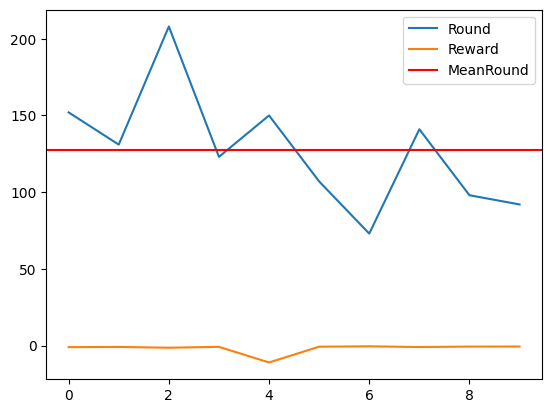

In [77]:
plt.plot(history['step'], label = 'Round')
# plt.plot(history['reward'], label = 'Reward')
plt.axhline(y = meanPlot, xmin = 0, xmax = 1, label = 'MeanRound', color = 'red')
plt.legend()
dqnNetwork.SaveNetwork(SAVEDPATH)

In [71]:
#TODO: 加上对memory的本地存储